In [1]:
# !rm -rf Busway-Traffic-Violation-Detection
# !git clone https://github.com/ariqbasyar/Busway-Traffic-Violation-Detection.git\
#   && cd /content/Busway-Traffic-Violation-Detection/\
#   && git checkout lane-detection

In [2]:
# %cd /content/Busway-Traffic-Violation-Detection/model/busway-lane-detection-yolo/

In [5]:
# !pip install Shapely

     |████████████████████████████████| 1.1 MB 3.5 MB/s eta 0:00:01


In [3]:
!ls

example.ipynb  example.py  model.py  models  utils  weights


In [6]:
import sys
import os
import torch
import numpy as np
import cv2

from model import preprocess, detect, box_label
from time import time
from pathlib import Path
from models.experimental import attempt_load

from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
ROOT = Path('/workspace/Busway-Traffic-Violation-Detection/model/vehicle-detection-yolo')
WEIGHT = ROOT / 'weights'

In [8]:
weight = WEIGHT / 'yolov5m-car-detection.pt'

In [9]:
random_state = np.random.RandomState(42)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')
model = attempt_load(weight, map_location=device)

using cuda


Fusing layers... 
Model Summary: 308 layers, 21053802 parameters, 0 gradients, 50.4 GFLOPs


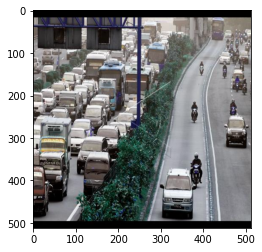

In [11]:
idx = '%03d.jpg' % random_state.randint(0,62)
main_img = cv2.imread(f'../../dataset/preprocessed_512x512/{idx}')
plt.imshow(main_img)
plt.show()

# Preprocess

In [12]:
preprocessed = preprocess(main_img,device)

# Detect

In [13]:
start = time()
pred, labels = detect(model,preprocessed)
print(f'inferenced in {(time() - start)*1E3:.2f}ms')

inferenced in 39.82ms


# Plot

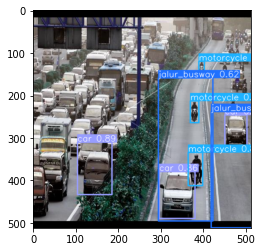

In [14]:
labeled_img = box_label(pred,main_img,labels)
plt.imshow(labeled_img)
plt.show()

In [31]:
def generate_polygon_from_rectangle(x0, y0, x1, y1):
    return [[x0,y0], [x1,y0], [x1,y1], [x0,y1]]

def extract_points_from_yolo(pred_item):
    return pred_item[0], pred_item[1], pred_item[2], pred_item[3]

car_violation_polygon = generate_polygon_from_rectangle(*extract_points_from_yolo(pred[3]))
car_legal_polygon = generate_polygon_from_rectangle(*extract_points_from_yolo(pred[0]))
busway_lane_polygon = generate_polygon_from_rectangle(*extract_points_from_yolo(pred[6]))

In [32]:
from shapely.geometry import Polygon

p_violation = Polygon(car_violation_polygon)
p_legal = Polygon(car_legal_polygon)
p_busway = Polygon(busway_lane_polygon)

In [38]:
p_busway.intersection(p_violation).area / p_violation.area

1.0

In [39]:
p_busway.intersection(p_legal).area / p_legal.area

0.0